In [25]:
import os
import glob
import re
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

from umap import UMAP
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans  # Import KMeans from sklearn.cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MeanShift
import matplotlib.colors as mcol

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
def get_feature(dataf, feature):
    vals = dataf[feature]
    return vals

In [27]:
path_data = "../Data/ARG_N_CYS"

path_cys_arg_pairp_f2_clt0 = os.path.join(path_data,"Pair-plot/output_cluster_1.txt")
path_cys_arg_pairp_f2_clt1 = os.path.join(path_data,"Pair-plot/output_cluster_2.txt")
path_cys_arg_pairp_f2_clt2 = os.path.join(path_data,"Pair-plot/output_cluster_3.txt")

In [28]:
df_pp_f2_clt0 = pd.read_csv(path_cys_arg_pairp_f2_clt0, sep="\t", header=None, skiprows=1, comment='#')
df_pp_f2_clt0.columns = ["Chain_S", "Res_S", "S_id",	"Res_S_num", "bfac_S", "bfac_S_BDB", "occ_S", "SASA_S",
                   "SASA_atom_S","Chain_N", "Res_N", "N_id", "Res_N_num", "bfac_N", "bfac_N_BDB" ,"occ_N", 
                   "SASA_N", "SASA_atom_N", "CN_id", "bfac_CN", "occu_CN", "Res_CS", "CS_id", 
                   "bfac_CS", "occu_CS", "distance_SN", "distanceCN", "distanceCS", "angle_CSN", "angle_CNS", 
                   "torsion_CS_NC", 'ngb_Res_toN', 'ngb_Res_toS',
                         "Close_contact", "greenBlob",
                         "ngb_Res_toS_hashed", "ngb_Res_toS_set",	"ngb_Res_toS_normalized",
                         "ngb_Res_toN_hashed", "ngb_Res_toN_set",	"ngb_Res_toN_normalized",
                         "filename"]

df_pp_f2_clt1 = pd.read_csv(path_cys_arg_pairp_f2_clt1, sep="\t", header=None, skiprows=1, comment='#')
df_pp_f2_clt1.columns = ["Chain_S", "Res_S", "S_id",	"Res_S_num", "bfac_S", "bfac_S_BDB", "occ_S", "SASA_S",
                   "SASA_atom_S","Chain_N", "Res_N", "N_id", "Res_N_num", "bfac_N", "bfac_N_BDB" ,"occ_N", 
                   "SASA_N", "SASA_atom_N", "CN_id", "bfac_CN", "occu_CN", "Res_CS", "CS_id", 
                   "bfac_CS", "occu_CS", "distance_SN", "distanceCN", "distanceCS", "angle_CSN", "angle_CNS", 
                   "torsion_CS_NC", 'ngb_Res_toN', 'ngb_Res_toS',
                         "Close_contact", "greenBlob",
                         "ngb_Res_toS_hashed", "ngb_Res_toS_set",	"ngb_Res_toS_normalized",
                         "ngb_Res_toN_hashed", "ngb_Res_toN_set",	"ngb_Res_toN_normalized",
                         "filename"]

df_pp_f2_clt2 = pd.read_csv(path_cys_arg_pairp_f2_clt2, sep="\t", header=None, skiprows=1, comment='#')
df_pp_f2_clt2.columns = ["Chain_S", "Res_S", "S_id",	"Res_S_num", "bfac_S", "bfac_S_BDB", "occ_S", "SASA_S",
                   "SASA_atom_S","Chain_N", "Res_N", "N_id", "Res_N_num", "bfac_N", "bfac_N_BDB" ,"occ_N", 
                   "SASA_N", "SASA_atom_N", "CN_id", "bfac_CN", "occu_CN", "Res_CS", "CS_id", 
                   "bfac_CS", "occu_CS", "distance_SN", "distanceCN", "distanceCS", "angle_CSN", "angle_CNS", 
                   "torsion_CS_NC", 'ngb_Res_toN', 'ngb_Res_toS',
                         "Close_contact", "greenBlob",
                         "ngb_Res_toS_hashed", "ngb_Res_toS_set",	"ngb_Res_toS_normalized",
                         "ngb_Res_toN_hashed", "ngb_Res_toN_set",	"ngb_Res_toN_normalized",
                         "filename"]

In [29]:
def hash_set(set_data):
    try:
        # Check if set_data is already a set or iterable
        if isinstance(set_data, (list, tuple, set)):
            # Convert to set if not already a set
            set_values = set(set_data)
        elif isinstance(set_data, str):
            # Parse string representation of set into a set of values
            set_values = set(eval(set_data))  # Use eval with caution to parse literal expressions
        else:
            # If set_data is a single value (e.g., int), convert it to a single-element set
            set_values = {set_data}

        # Sort the set values and convert to tuple for hashing
        sorted_tuple = tuple(sorted(set_values))
        hashed_value = hash(sorted_tuple)

        return hashed_value

    except Exception as e:
        print(f"Error processing set_data: {e}")
        return None

In [30]:
def feature_collector(dataini, output=False):
    dataset = dataini.drop(columns=['Chain_S', 'Res_S', 'S_id', 'CS_id', 'Chain_N', "Res_CS",
                                'Res_N', 'N_id', 'CN_id', 'Res_S_num', 'Res_N_num',
                                    "occ_S", "occ_N",
                                    # "occ_CS", "occ_CN",
                                    "Close_contact"])

    sasa_s = get_feature(dataset, "SASA_S").astype(float)
    sasa_atom_s = get_feature(dataset, "SASA_atom_S").astype(float)
    sasa_n = get_feature(dataset, "SASA_N").astype(float)
    sasa_atom_n = get_feature(dataset, "SASA_atom_N").astype(float)
    
    
    bfac_s = get_feature(dataset, "bfac_S").astype(float)
    bfac_s_bdb = get_feature(dataset, "bfac_S_BDB").astype(float)
    bfac_n = get_feature(dataset, "bfac_N").astype(float)
    bfac_n_bdb = get_feature(dataset, "bfac_N_BDB").astype(float)
    bfac_cn = get_feature(dataset, "bfac_CN").astype(float)
    bfac_cs = get_feature(dataset, "bfac_CS").astype(float)
    
    dist_sn = get_feature(dataset, "distance_SN").astype(float)
    dist_cn = get_feature(dataset, "distanceCN").astype(float)
    dist_cs = get_feature(dataset, "distanceCS").astype(float)
    
    angle_csn = get_feature(dataset, "angle_CSN").astype(float)
    angle_cns = get_feature(dataset, "angle_CNS").astype(float)
    tors_cs_nc = get_feature(dataset, "torsion_CS_NC").astype(float)

    nres_s = dataset['ngb_Res_toS'].apply(hash_set).astype(float)
    nres_s_norm = (nres_s - nres_s.mean()) / nres_s.std()

    nres_n = dataset['ngb_Res_toN'].apply(hash_set).astype(float)
    nres_n_norm = (nres_n - nres_n.mean()) / nres_n.std()


    if output==False:
        return sasa_s, sasa_atom_s, sasa_n, sasa_atom_n, bfac_s, bfac_s_bdb, bfac_n, bfac_n_bdb, bfac_cn, bfac_cs, dist_sn, dist_cn, dist_cs, angle_csn, angle_cns, tors_cs_nc, nres_s, nres_n, nres_s_norm, nres_n_norm
    else:
        nres_s_norm2 = dataset['ngb_Res_toS_normalized']
        nres_n_norm2 = dataset['ngb_Res_toN_normalized']
        return sasa_s, sasa_atom_s, sasa_n, sasa_atom_n, bfac_s, bfac_s_bdb, bfac_n, bfac_n_bdb, bfac_cn, bfac_cs, dist_sn, dist_cn, dist_cs, angle_csn, angle_cns, tors_cs_nc, nres_s, nres_n, nres_s_norm, nres_n_norm, nres_s_norm2, nres_n_norm2


In [31]:
def df_creator(dataini, output=False):

    if output==False:
        sasa_s, sasa_atom_s, sasa_n, sasa_atom_n, bfac_s, bfac_s_bdb, bfac_n, bfac_n_bdb, bfac_cn, bfac_cs, dist_sn, dist_cn, dist_cs, angle_csn, angle_cns, tors_cs_nc, nres_s, nres_n, nres_s_norm, nres_n_norm= feature_collector(dataini) 
    else:
        sasa_s, sasa_atom_s, sasa_n, sasa_atom_n, bfac_s, bfac_s_bdb, bfac_n, bfac_n_bdb, bfac_cn, bfac_cs, dist_sn, dist_cn, dist_cs, angle_csn, angle_cns, tors_cs_nc, nres_s, nres_n, nres_s_norm, nres_n_norm, nres_s_norm2, nres_n_norm2= feature_collector(dataini, output)
    dataset = dataini.drop(columns=['Chain_S', 'Res_S', 'S_id', 'CS_id', 'Chain_N', "Res_CS",
                                'Res_N', 'N_id', 'CN_id','greenBlob'])
    if output==False:
        visu_df = pd.DataFrame(
        {
        'SASA_N': sasa_n,
        'SASA_S': sasa_s,
        'SASA_atom_N':   sasa_atom_n,
        'SASA_atom_S':   sasa_atom_s,
        'bfac_N_BDB': bfac_n_bdb,
        'bfac_N': bfac_n,
        'bfac_S_BDB': bfac_s_bdb,
        'bfac_S': bfac_s,
        'distance_CN': dist_cn,
        'distance_SN': dist_sn,
        'angle_CSN': angle_csn, 
        'angle_CNS': angle_cns, 
        'torsion_CS_NC': tors_cs_nc, 
        'ngb_Res_toS_normalized': nres_s_norm,
        'ngb_Res_toN_normalized': nres_n_norm,
        })
    else:
        visu_df = pd.DataFrame(
        {
        'SASA_N': sasa_n,
        'SASA_S': sasa_s,
        'SASA_atom_N':   sasa_atom_n,
        'SASA_atom_S':   sasa_atom_s,
        'bfac_N_BDB': bfac_n_bdb,
        'bfac_N': bfac_n,
        'bfac_S_BDB': bfac_s_bdb,
        'bfac_S': bfac_s,
        'distance_CN': dist_cn,
        'distance_SN': dist_sn,
        'angle_CSN': angle_csn, 
        'angle_CNS': angle_cns, 
        'torsion_CS_NC': tors_cs_nc, 
        'ngb_Res_toS_normalized': nres_s_norm,
        'ngb_Res_toN_normalized': nres_n_norm,
        'ngb_Res_toS_normalized2': nres_s_norm2,
        'ngb_Res_toN_normalized2': nres_n_norm2,
        })
        

    visu_df['filename'] = dataset['filename']
    visu_df['index'] = np.arange(visu_df.shape[0])

    return visu_df



dataset_pp_f2_clt0 = df_creator(df_pp_f2_clt0, True)
dataset_pp_f2_clt1 = df_creator(df_pp_f2_clt1, True)
dataset_pp_f2_clt2 = df_creator(df_pp_f2_clt2, True)


dataset_pp_f2_clt0['dataset'] = "Prob. NOS 1"
dataset_pp_f2_clt2['dataset'] = "Improb. NOS"
dataset_pp_f2_clt1['dataset'] = "Prob. NOS 2"
combined_data_pp = pd.concat([dataset_pp_f2_clt0,  dataset_pp_f2_clt1, dataset_pp_f2_clt2]) 

### PairPlot

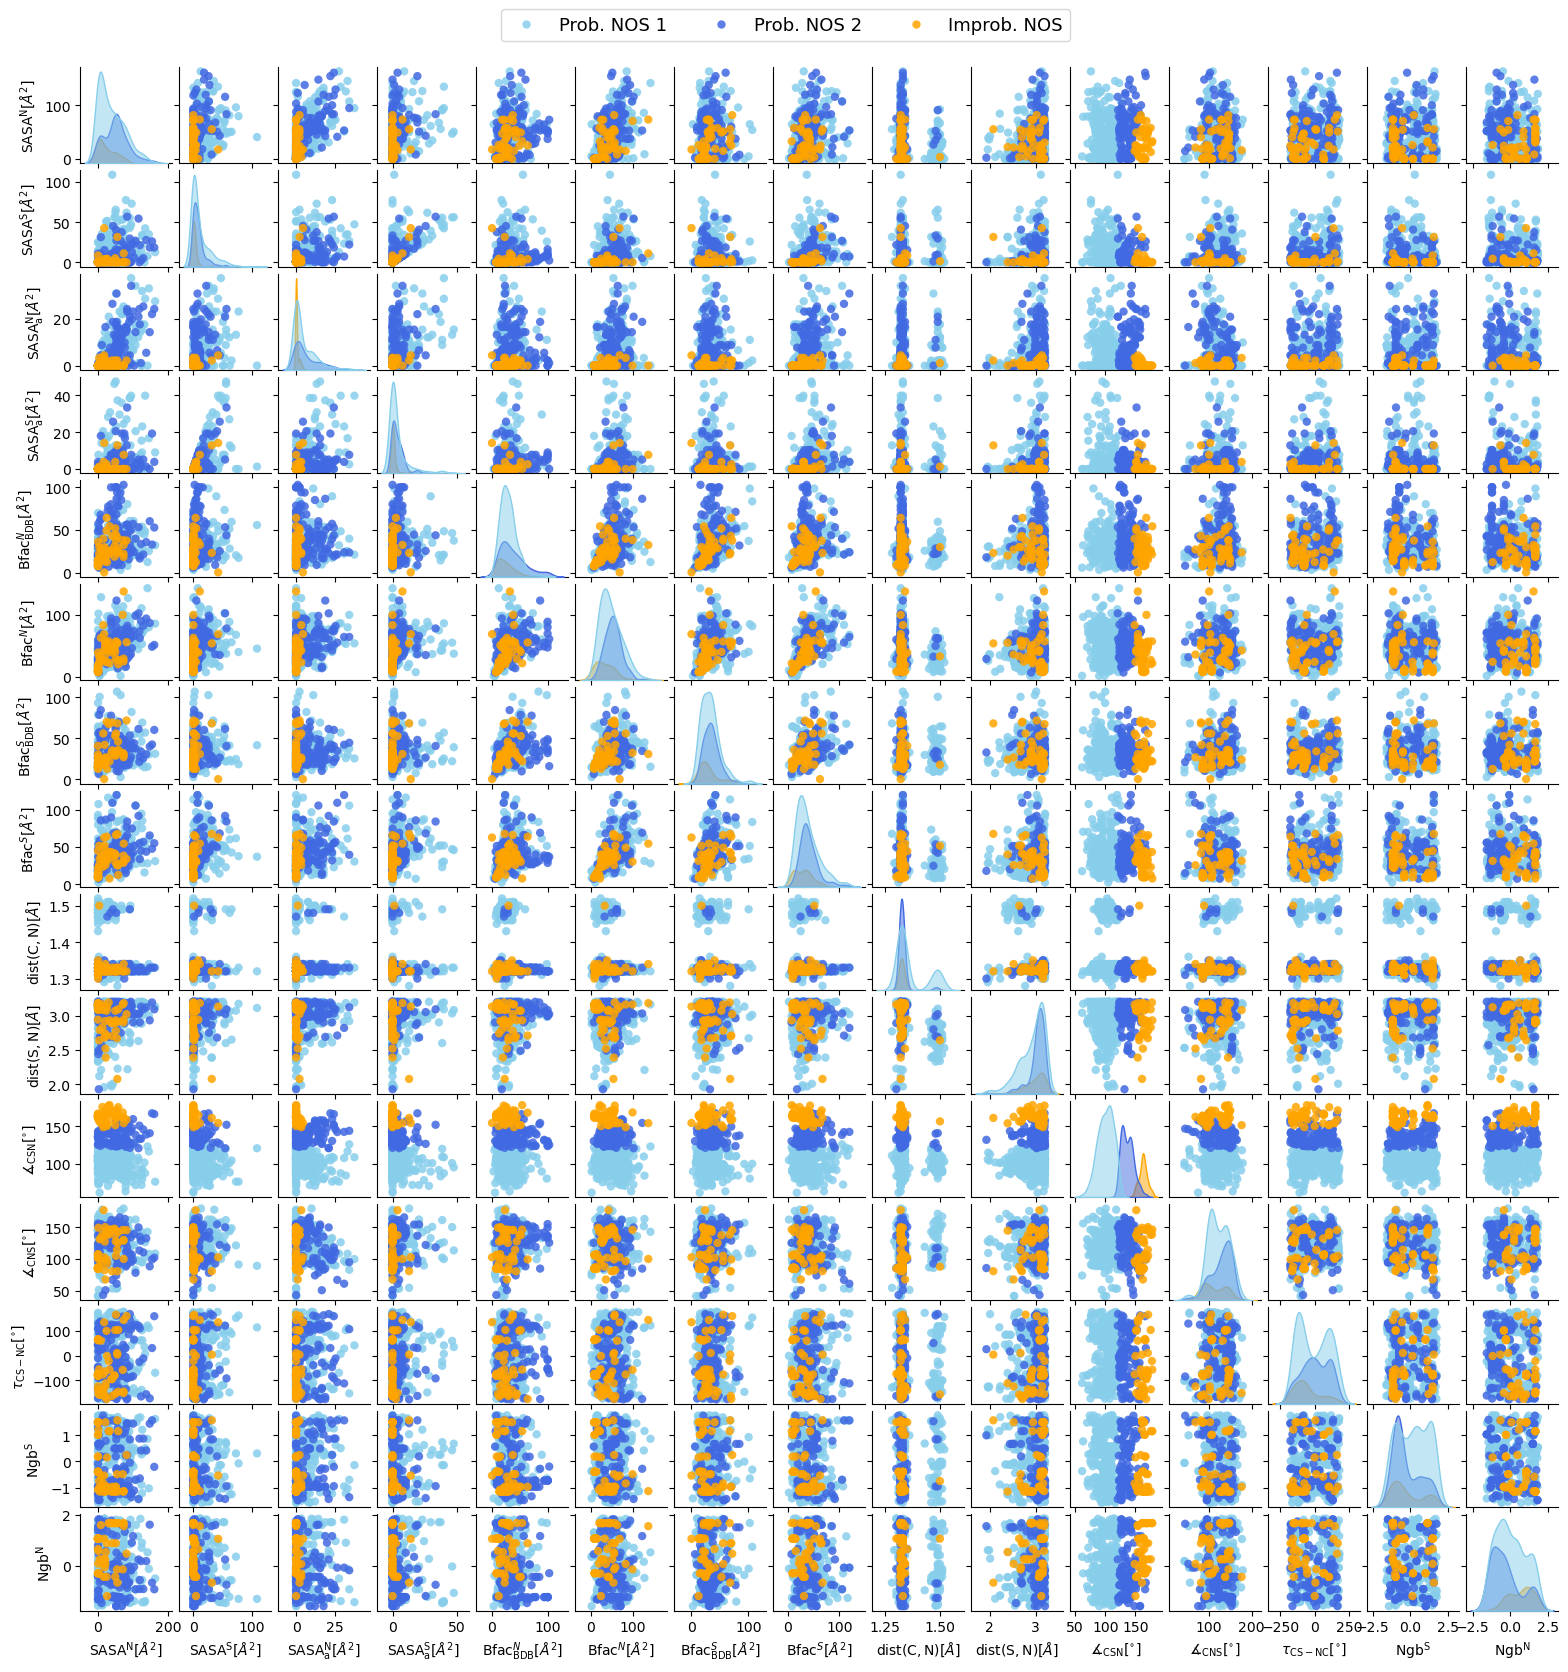

In [32]:
custom_palette = {'Prob. NOS 1': 'skyblue', 'Prob. NOS 2': 'royalblue', 'Improb. NOS': 'orange'}

labels=[r"${\rm SASA}^{\rm N}[\AA^{2}]$", 
        r"${\rm SASA}^{\rm S}[\AA^{2}]$", 
        r"${\rm SASA}_{\rm a}^{\rm N}[\AA^{2}]$" ,
        r"${\rm SASA}_{\rm a}^{\rm S}[\AA^{2}]$" ,
        r"${\rm Bfac}^{N}_{\rm BDB}[\AA^{2}]$",
        r"${\rm Bfac}^{N}[\AA^{2}]$",
        r"${\rm Bfac}^{S}_{\rm BDB}[\AA^{2}]$",
        r"${\rm Bfac}^{S}[\AA^{2}]$",
        r"${\rm dist(C,N)}[\AA]$", 
        r"${\rm dist(S,N)}[\AA]$",
        r"${\measuredangle}_{\rm CSN}[^{\circ}]$",
        r"${\measuredangle}_{\rm CNS}[^{\circ}]$", 
        r"${\tau}_{\rm CS-NC}[^{\circ}]$",
        r"${\rm Ngb}^{\rm S}$",
        r"${\rm Ngb}^{\rm N}$"]


pp = sns.pairplot(combined_data_pp.drop(columns=['index', 'filename', 'ngb_Res_toS_normalized', 'ngb_Res_toN_normalized']), hue='dataset', diag_kind='kde',
                      plot_kws=dict(alpha=0.85, edgecolor='none'),
                      diag_kws=dict(alpha=0.5),
                      palette=custom_palette, corner=False)

pp.x_vars = labels
pp.y_vars = labels
pp._add_axis_labels()

pp._legend.remove()
handles = pp._legend_data.values()
labels = pp._legend_data.keys()
pp.figure.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.47, 1.03), ncol=3, fontsize=13)

pp.figure.set_size_inches(16,16)

pp.savefig("../Figs/Extended_figure/Fig1_pairplot_ARG_N_CYS.pdf", bbox_inches='tight',pad_inches = 0, dpi = 400)
